In [ ]:
import sys
!{sys.executable} -m pip install uv==0.6.14
!{sys.executable} -m uv pip sync ../requirements.txt

# Imports

In [2]:
import os

os.environ["BAYBE_TELEMETRY_ENABLED"] = "false"

import string
import random
from tqdm import tqdm

from baybe.campaign import Campaign
from baybe.exceptions import UnusedObjectWarning
from baybe.parameters import CustomDiscreteParameter, CategoricalParameter
from baybe.targets import NumericalTarget
from baybe.searchspace import SearchSpace
from baybe.recommenders import RandomRecommender
from utils import backtest_plot
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
from shapely.geometry import Point
from matplotlib.colors import Normalize

from botorch.exceptions import InputDataWarning
from linear_operator.utils.warnings import NumericalWarning
import warnings

warnings.simplefilter(
    "ignore", (InputDataWarning, NumericalWarning, UnusedObjectWarning)
)

import baybe

print(baybe.__version__)

0.12.2


# Data

In [3]:
cali_df = pd.read_csv("../data/california_housing.csv", dtype={"ZIP": str})
cali_df.drop_duplicates(subset=["Latitude", "Longitude"], inplace=True)
cali_df.head()

,ZIP,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MEDV
0,103,2.87270,25.0,4.365347,1.007921,4579.0,4.533663,34.230,-118.550,2.45100
1,13359,10.92370,44.0,7.837963,1.106481,498.0,2.305556,34.140,-118.430,5.00001
2,1387,4.61405,14.0,5.637666,1.061757,8752.5,2.607055,34.420,-118.455,1.91600
3,2037,6.80805,36.0,7.405322,1.185141,729.0,1.999618,32.850,-117.260,5.00001
4,21080,4.98795,22.5,6.075155,1.193182,876.0,2.454545,33.635,-117.975,2.40750


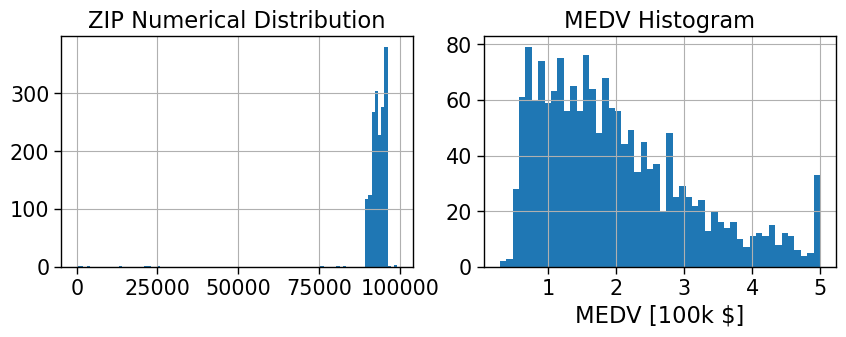

In [4]:
plt.subplot(1, 2, 1)
cali_df.ZIP.astype(float).hist(bins=100)
plt.title("ZIP Numerical Distribution")

plt.subplot(1, 2, 2)
cali_df.MEDV.hist(bins=50)
plt.title("MEDV Histogram")
plt.xlabel('MEDV [100k $]')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gcf().set_size_inches((10, 3))
plt.gcf().savefig(
    "../figures/custom_encodings_histograms.svg", format="svg", transparent=True
)

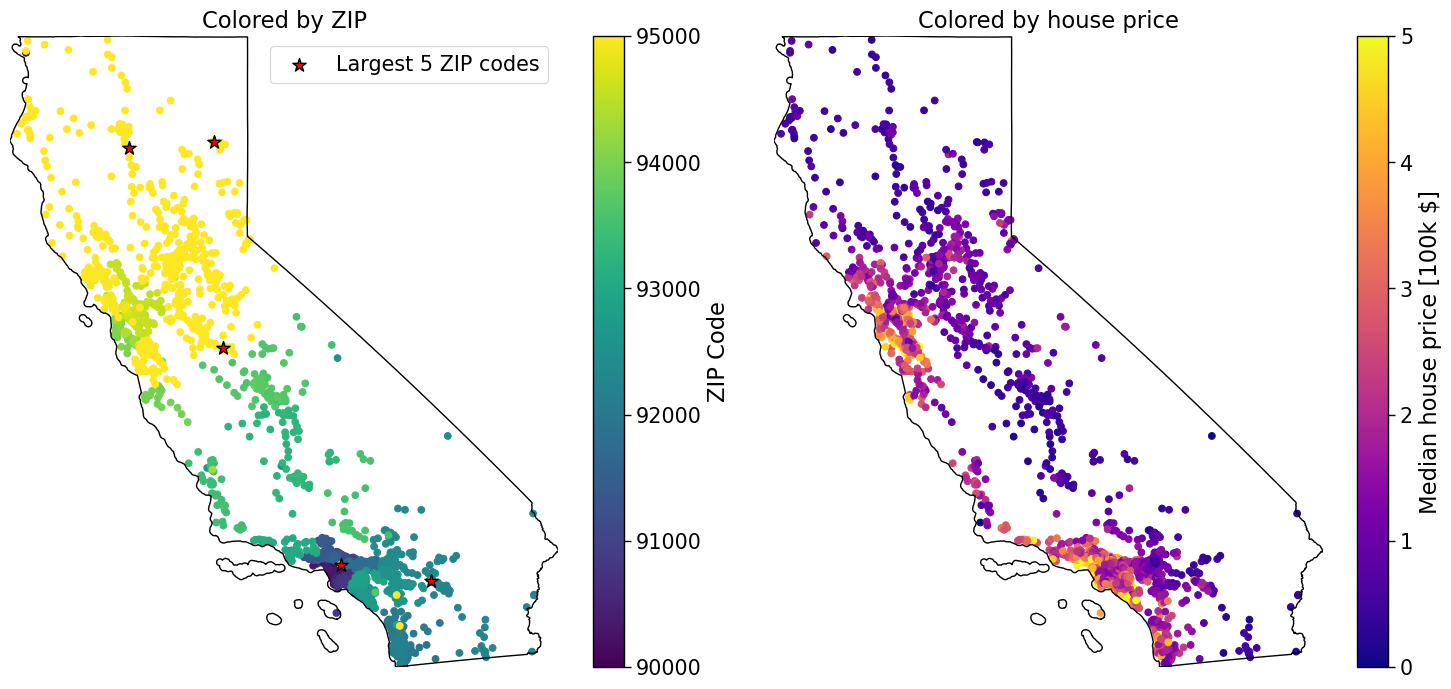

In [5]:
# Load US states shapefile
us_states = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip"
)

# Filter for California
california = us_states[us_states["NAME"] == "California"]

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(cali_df["Longitude"], cali_df["Latitude"])]
cali_gdf = gpd.GeoDataFrame(cali_df, geometry=geometry, crs="EPSG:4326")

# Get largest five ZIP codes
cali_gdf["ZIP"] = pd.to_numeric(cali_df["ZIP"], errors="coerce")
top_5_zip = cali_gdf.nlargest(5, "ZIP")

# Create a subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1: Colored by ZIP
axs[0].set_title("Colored by ZIP")
california.boundary.plot(ax=axs[0], color="black", linewidth=1)

# Create a custom normalization
norm = Normalize(vmin=90000, vmax=95000)

scatter1 = cali_gdf.plot(
    ax=axs[0], column="ZIP", cmap="viridis", norm=norm, legend=False
)
axs[0].set_xlim(california.total_bounds[0], california.total_bounds[2])
axs[0].set_ylim(california.total_bounds[1], california.total_bounds[3])

# Add custom colorbar for ZIP
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=axs[0])
cbar1.set_label("ZIP Code")

# Highlight selected ZIP codes
axs[0].scatter(
    top_5_zip.geometry.x,
    top_5_zip.geometry.y,
    c="red",
    s=100,
    marker="*",
    edgecolor="black",
    linewidth=1,
    label="Largest 5 ZIP codes",
)

# Plot 2: Colored by House Price
axs[1].set_title("Colored by house price")
california.boundary.plot(ax=axs[1], color="black", linewidth=1)
scatter2 = cali_gdf.plot(ax=axs[1], column="MEDV", cmap="plasma", legend=False)
axs[1].set_xlim(california.total_bounds[0], california.total_bounds[2])
axs[1].set_ylim(california.total_bounds[1], california.total_bounds[3])

# Add colorbar for House Price
norm = Normalize(vmin=0, vmax=5)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar2 = plt.colorbar(sm, ax=axs[1])
cbar2.set_label("Median house price [100k $]")

# Remove axis labels
for ax in axs:
    ax.set_axis_off()

axs[0].legend()

# Adjust color scale for house prices to show original values
scatter2.collections[0].set_clim(cali_gdf["MEDV"].min(), cali_gdf["MEDV"].max())

plt.tight_layout()
plt.gcf().savefig("../figures/custom_encodings_map.svg", format="svg", transparent=True)
plt.show()

# Settings

In [6]:
from baybe.utils.random import set_random_seed

N_DOE_ITERATIONS = 50
N_MC_ITERATIONS = 200
BATCH_SIZE = 1
RANDOM_SEED = 1337
set_random_seed(RANDOM_SEED)

# Measurement Loop Including Label Shuffling
In this loop we perform the Monte Carlo recommend-measure cycle. 
In addition to the responsibilities typically taken over by `simulate_scenarios`, this hand-coded loop also randomizes the labels in each MC iteration.
This is done to avoid spurious ordering effects that can result in an interplay between integer / one-hot encoding enhibiting unrealistic performance.
For instance, the ZIP code labels at the very bottom-end can have special roles, e.g. by the larges cities having especially small ZIP codes assigned to them.
The result can be a trivial order in that the largest/smallest ZIP codes have trivially the highest/lowes house price.
This would not be changed by randomizing the mere order of labels in the parameter, but needs actually changing the label name by adding a random alpha-numeric string in front of it.

In [7]:
results = []
for k_mc in tqdm(range(N_MC_ITERATIONS)):
    # Prepend a random string to the ZIps to avoid spurious ordering present as some municipalities receive special ordering
    temp_df = cali_df.copy()
    temp_df["ZIP"] = (
        cali_df["ZIP"]
        .apply(
            lambda x: f"{''.join(random.choices(string.ascii_letters + string.digits, k=5))}_{x}"
        )
        .astype(str)
    )
    custom_data = temp_df[["ZIP", "Latitude", "Longitude"]].sample(frac=1.0)
    custom_data.set_index("ZIP", inplace=True)
    objective = NumericalTarget(name="MEDV", mode="MAX").to_objective()

    scenarios = {
        "Latitude-Longitude": Campaign(
            searchspace=SearchSpace.from_product(
                [
                    CustomDiscreteParameter(
                        name="ZIP", data=custom_data, decorrelate=False
                    )
                ]
            ),
            objective=objective,
        ),
        "OHE": Campaign(
            searchspace=SearchSpace.from_product(
                [CategoricalParameter(name="ZIP", values=temp_df.ZIP, encoding="OHE")]
            ),
            objective=objective,
        ),
        "INT": Campaign(
            searchspace=SearchSpace.from_product(
                [CategoricalParameter(name="ZIP", values=temp_df.ZIP, encoding="INT")]
            ),
            objective=objective,
        ),
        "Random": Campaign(
            searchspace=SearchSpace.from_product(
                [CategoricalParameter(name="ZIP", values=temp_df.ZIP, encoding="INT")]
            ),
            objective=objective,
            recommender=RandomRecommender(),
        ),
    }

    for name, campaign in scenarios.items():
        for k_iter in range(N_DOE_ITERATIONS):
            rec = campaign.recommend(BATCH_SIZE)
            measurement = rec.copy()
            targets = [t.name for t in campaign.targets]
            measurement[targets] = pd.merge(temp_df, rec, on=["ZIP"], how="inner")[
                targets
            ].values
            campaign.add_measurements(measurement)

            res = {
                "Scenario": name,
                "Monte_Carlo_Run": k_mc,
                "Iteration": k_iter,
                "Num_Experiments": (k_iter + 1) * BATCH_SIZE,
            }

            for t in campaign.targets:
                res[f"{t.name}_Measurements"] = measurement[t.name].values
                res[f"{t.name}_IterBest"] = measurement[t.name].max()
                res[f"{t.name}_CumBest"] = campaign.measurements[t.name].max()

            results.append(res)

results = pd.DataFrame(results)

results.rename(
    columns={
        "Scenario": "ZIP Encoding",
        "Num_Experiments": "Number of experiments",
        "MEDV_CumBest": "Running best house price",
    },
    inplace=True,
)

results

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [5:34:01<00:00, 100.21s/it]


,ZIP Encoding,Monte_Carlo_Run,Iteration,Number of experiments,MEDV_Measurements,MEDV_IterBest,Running best house price
0,Latitude-Longitude,0,0,1,[3.221287142857143],3.221287,3.221287
1,Latitude-Longitude,0,1,2,[0.45],0.450000,3.221287
2,Latitude-Longitude,0,2,3,[0.8301666666666666],0.830167,3.221287
3,Latitude-Longitude,0,3,4,[2.6265],2.626500,3.221287
4,Latitude-Longitude,0,4,5,[1.4535],1.453500,3.221287
...,...,...,...,...,...,...,...
39995,Random,199,45,46,[2.762941176470588],2.762941,5.000010
39996,Random,199,46,47,[0.599],0.599000,5.000010
39997,Random,199,47,48,[1.156],1.156000,5.000010
39998,Random,199,48,49,[1.8498571428571429],1.849857,5.000010


In [8]:
results.to_csv("../results/custom_encodings.csv", index=None)

# Visualization

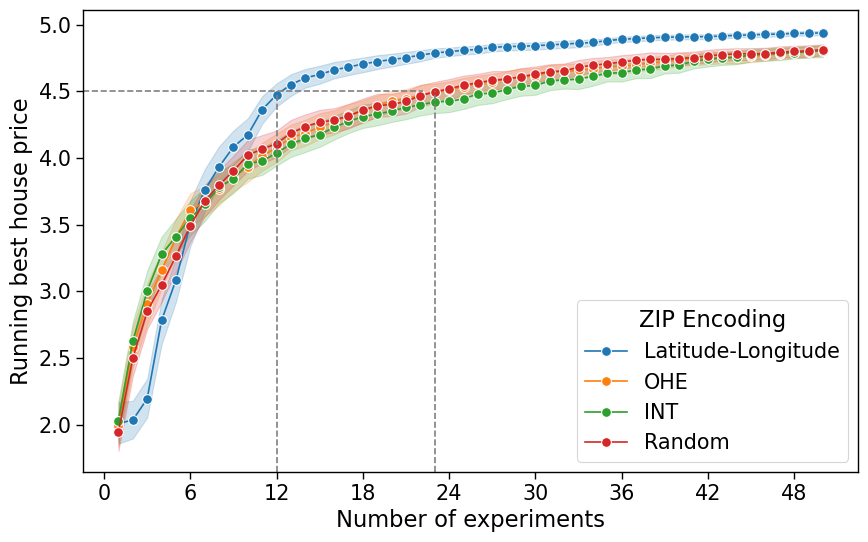

In [9]:
results = pd.read_csv("../results/custom_encodings.csv")

backtest_plot(
    df=results,
    figure_name="custom_encodings",
    x="Number of experiments",
    y="Running best house price",
    hue="ZIP Encoding",
    indicator_y=4.5,
    indicator_labels=["Latitude-Longitude", "OHE"],
)